In [94]:
import torch
import torch.nn as nn
import torchvision as tv
from mpmath.calculus.extrapolation import nprod
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

In [8]:
trans = tv.transforms.Compose([
    tv.transforms.ToTensor()
])

In [9]:
ds_mnist = tv.datasets.MNIST('./datasets', download=True, transform=trans)

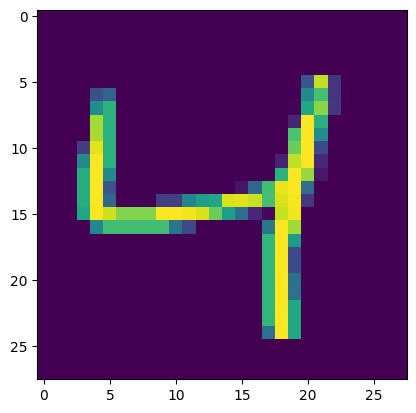

In [18]:
ds_mnist[0][0].numpy()[0].shape
plt.imshow(ds_mnist[2][0].numpy()[0])

In [19]:
batch_size = 16
dataloader = torch.utils.data.DataLoader(
    ds_mnist, batch_size=batch_size , shuffle=True, 
    num_workers=1, drop_last=True
)


In [20]:
for img, label  in dataloader:
    print(img.shape, label.shape)
    break

torch.Size([16, 1, 28, 28]) torch.Size([16])


In [126]:
class Neural_nambers(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(28*28, 100)
        self.linear2 = nn.Linear(100, 10)
        self.act = nn.ReLU()
    
    def forward(self, x):
        x = x.flatten(start_dim=1)
        out = self.linear1(x)
        out = self.act(out)
        out = self.linear2(out)
        
        return out
        

In [127]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [128]:
model = Neural_nambers()
model.to(DEVICE)

Neural_nambers(
  (linear1): Linear(in_features=784, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)

In [129]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)


79510

In [130]:
loss_fn = nn.CrossEntropyLoss()

In [131]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

In [132]:
def accuracy(pred, label):
    answer = F.softmax(pred, dim=1).argmax(1) == label.argmax(1)
    answer = answer.to('cpu').numpy()
    # print(answer.shape)
    # print(answer)
    # print(answer.sum())
    return answer.mean()

In [133]:
epochs = 10

for epoch in range(epochs):
    loss_val = 0
    acc_val = 0
    for img, label in (pbar :=  tqdm(dataloader)):
        optimizer.zero_grad()
        label = F.one_hot(label, 10).float().to(DEVICE)
        pred = model(img.to(DEVICE))
        
        loss = loss_fn(pred, label)
        loss.backward()
        loss_item = loss.item()
        loss_val += loss_item
        
        optimizer.step()
        
        acc_current = accuracy(pred, label)
        acc_val += acc_current
        
        pbar.set_description(f'Loss: {loss_item:.4f}\accuracy: {acc_current:.4f}')
    print(f'Epoch: {epoch+1}/{epochs}, Loss: {loss_val/len(dataloader)}')
    print(f'Epoch: {epoch+1}/{epochs}, Accuracy: {acc_val/len(dataloader)}')

Loss: 0.2053ccuracy: 1.0000: 100%|██████████| 3750/3750 [00:29<00:00, 127.56it/s]


Epoch: 1/10, Loss: 0.632910166221857
Epoch: 1/10, Accuracy: 0.84745


Loss: 0.6485ccuracy: 0.8125: 100%|██████████| 3750/3750 [00:27<00:00, 138.27it/s]


Epoch: 2/10, Loss: 0.30773128780821957
Epoch: 2/10, Accuracy: 0.9128


Loss: 0.7246ccuracy: 0.8125: 100%|██████████| 3750/3750 [00:27<00:00, 135.26it/s]


Epoch: 3/10, Loss: 0.25996062009955445
Epoch: 3/10, Accuracy: 0.92685


Loss: 0.1700ccuracy: 0.9375: 100%|██████████| 3750/3750 [00:26<00:00, 142.23it/s]


Epoch: 4/10, Loss: 0.2274499714533488
Epoch: 4/10, Accuracy: 0.93615


Loss: 0.2504ccuracy: 0.8750: 100%|██████████| 3750/3750 [00:25<00:00, 144.91it/s]


Epoch: 5/10, Loss: 0.20164310142633815
Epoch: 5/10, Accuracy: 0.9434833333333333


Loss: 0.2458ccuracy: 0.8750: 100%|██████████| 3750/3750 [00:26<00:00, 140.42it/s]


Epoch: 6/10, Loss: 0.18165110219394168
Epoch: 6/10, Accuracy: 0.9495166666666667


Loss: 0.1225ccuracy: 0.9375: 100%|██████████| 3750/3750 [00:29<00:00, 129.23it/s]


Epoch: 7/10, Loss: 0.1641262916802118
Epoch: 7/10, Accuracy: 0.9539333333333333


Loss: 0.0283ccuracy: 1.0000: 100%|██████████| 3750/3750 [00:28<00:00, 133.89it/s]


Epoch: 8/10, Loss: 0.14982174316477032
Epoch: 8/10, Accuracy: 0.95845


Loss: 0.1091ccuracy: 1.0000: 100%|██████████| 3750/3750 [00:24<00:00, 151.84it/s]


Epoch: 9/10, Loss: 0.13806148388534784
Epoch: 9/10, Accuracy: 0.9614666666666667


Loss: 0.2023ccuracy: 0.9375: 100%|██████████| 3750/3750 [00:25<00:00, 149.30it/s]

Epoch: 10/10, Loss: 0.12711483243666588
Epoch: 10/10, Accuracy: 0.9650166666666666


In [124]:
accuracy(pred, label)

1.0

In [134]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [155]:
img = cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE)

img = np.expand_dims(img, axis=0)
img = np.expand_dims(img, axis=0)
img =img.astype(np.float32)/255.0

In [156]:
img.shape

(1, 1, 28, 28)

In [157]:
t_img = torch.from_numpy(img).to(DEVICE)
test_img = model(t_img)

In [158]:
F.softmax(test_img.to('cpu')).detach().numpy()


C:\Users\matsvei\AppData\Local\Temp\ipykernel_3304\1020567459.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  F.softmax(test_img.to('cpu')).detach().numpy()


array([[1.2505171e-03, 3.0051428e-10, 4.2540213e-01, 5.7325679e-01,
        2.2744715e-09, 8.0797756e-05, 9.0208818e-09, 2.1488363e-08,
        9.6981394e-06, 5.6504312e-10]], dtype=float32)